# Citi Bike × NYPD: Usage patterns + insurer decision assets

This notebook is built to work with the repo Make targets (e.g. `make report MODE=nyc YEARS="2023 2024" MONTHS="1 2 3"`).

It **always prefers the current run** (your `summaries/<RUN_TAG>/` folder) when you pass `YEARS/MONTHS`, so the report reflects exactly what you ingested.


## How to run (recommended)

From the repo root:

```bash
make all-both YEARS="YYYY YYYY..." MONTHS="1 2 .. 12" PURGE_OLD_ZIPS=NO 
check README
```

The Makefile sets environment variables (e.g. `CITIBIKE_PARQUET_DIR`, `CITIBIKE_YEARS`, `CITIBIKE_MONTHS`) which this notebook reads.


In [1]:
# --- Setup (STRICT): locate repo, resolve RUN_DIR + PARQUET_DIR, load summaries safely ---
from __future__ import annotations

from pathlib import Path
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

try:
    from IPython.display import display, Markdown
    _HAVE_IPYTHON = True
except Exception:
    display = print
    Markdown = lambda x: x
    _HAVE_IPYTHON = False

# Ensure figures render into the executed notebook outputs
try:
    get_ipython().run_line_magic("matplotlib", "inline")
except Exception:
    pass

plt.ioff()  # nbconvert-friendly (prevents interactive windows)

def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start, *start.parents]:
        if (p / "Makefile").exists():
            return p
    return start

REPO_ROOT = find_repo_root(Path.cwd())
SUMMARIES_ROOT = REPO_ROOT / "summaries"

def _parse_int_list(val: str | None):
    if val is None:
        return None
    s = str(val).strip()
    if not s:
        return None
    parts = re.split(r"[,\s]+", s)
    out = []
    for p in parts:
        if not p:
            continue
        try:
            out.append(int(p))
        except Exception:
            pass
    return out or None

# Inputs from Makefile (recommended)
PARQUET_DIR_ENV = (os.environ.get("CITIBIKE_PARQUET_DIR") or "").strip()
RUN_DIR_ENV     = (os.environ.get("CITIBIKE_RUN_DIR") or "").strip()
MODE_ENV        = (os.environ.get("CITIBIKE_MODE") or os.environ.get("MODE") or "").strip().lower()

YEARS_FILTER  = _parse_int_list(os.environ.get("CITIBIKE_YEARS")  or os.environ.get("YEARS"))
MONTHS_FILTER = _parse_int_list(os.environ.get("CITIBIKE_MONTHS") or os.environ.get("MONTHS"))

PARQUET_DIR = Path(PARQUET_DIR_ENV) if PARQUET_DIR_ENV else Path()
if RUN_DIR_ENV:
    RUN_DIR = Path(RUN_DIR_ENV)
else:
    # Infer RUN_TAG from parquet folder name; expects .../citibike_parquet/<RUN_TAG>
    run_tag = PARQUET_DIR.name if str(PARQUET_DIR).strip() else ""
    RUN_DIR = SUMMARIES_ROOT / run_tag if run_tag else Path()

# Resolve relative -> absolute (relative to REPO_ROOT)
if RUN_DIR and (not RUN_DIR.is_absolute()):
    RUN_DIR = (REPO_ROOT / RUN_DIR).resolve()
if PARQUET_DIR and (not PARQUET_DIR.is_absolute()):
    PARQUET_DIR = (REPO_ROOT / PARQUET_DIR).resolve()

# ---- STRICT checks ----
if not (REPO_ROOT / "Makefile").exists():
    raise FileNotFoundError(
        f"Expected to find repo root (Makefile) by walking up from CWD.\n"
        f"  CWD: {Path.cwd().resolve()}\n"
        f"  Derived REPO_ROOT: {REPO_ROOT}"
    )

if not SUMMARIES_ROOT.exists():
    raise FileNotFoundError(
        f"Expected summaries/ folder not found at: {SUMMARIES_ROOT}\n"
        "Run: make summarize (or make all) first."
    )

if not RUN_DIR.exists():
    raise FileNotFoundError(
        f"Expected summaries run_dir not found:\n  {RUN_DIR}\n"
        "Run: make summarize (or make all) first."
    )

if not PARQUET_DIR.exists():
    raise FileNotFoundError(
        f"Expected parquet dir not found:\n  {PARQUET_DIR}\n"
        "Run: make ingest (or make all) first."
    )

REQUIRED_RUN_FILES = [
    "citibike_trips_by_year.csv",
    "citibike_trips_by_month.csv",
    "citibike_trips_by_dow.csv",
    "citibike_trips_by_hour.csv",
]
missing = [f for f in REQUIRED_RUN_FILES if not (RUN_DIR / f).exists()]
if missing:
    raise FileNotFoundError(
        "Missing required summary CSVs in run_dir:\n"
        f"  {RUN_DIR}\n"
        f"Missing: {missing}\n"
        "Run: make summarize (or make all) first."
    )

print("REPO_ROOT:", REPO_ROOT)
print("PARQUET_DIR:", PARQUET_DIR)
print("RUN_DIR:", RUN_DIR)
print("MODE (env):", MODE_ENV or "(not set)")
print("YEARS_FILTER:", YEARS_FILTER, "MONTHS_FILTER:", MONTHS_FILTER)

# Where to save figures (also show inline)
FIG_DIR = REPO_ROOT / "reports" / RUN_DIR.name / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)
print("FIG_DIR:", FIG_DIR)

def savefig(filename: str):
    out = FIG_DIR / filename
    plt.savefig(out, dpi=200, bbox_inches="tight")
    print("Saved:", out)

def read_csv(path: Path) -> pd.DataFrame:
    return pd.read_csv(path)

# ---- Load per-run summary CSVs ----
df_year  = read_csv(RUN_DIR / "citibike_trips_by_year.csv")
df_month = read_csv(RUN_DIR / "citibike_trips_by_month.csv")
df_dow   = read_csv(RUN_DIR / "citibike_trips_by_dow.csv")
df_hour  = read_csv(RUN_DIR / "citibike_trips_by_hour.csv")

# Optional per-run outputs
station_path = RUN_DIR / "citibike_station_exposure.csv"
df_station = read_csv(station_path) if station_path.exists() else None

risk_path = RUN_DIR / "station_risk_exposure_plus_crashproximity.csv"
df_risk = read_csv(risk_path) if risk_path.exists() else None

highlights_path = RUN_DIR / "summary_highlights.md"

# Mode detection (prefer data, else env)
mode = (
    str(df_year["mode"].iloc[0]).lower()
    if ("mode" in df_year.columns and len(df_year))
    else (MODE_ENV or "unknown")
)
print("Detected mode:", mode)

# ---- Compare tables (optional) ----
# If YEARS/MONTHS filters are passed (e.g., Jan–Mar), we default to THIS run only.
USE_COMPARE = (YEARS_FILTER is None and MONTHS_FILTER is None)
COMPARE_DIR = SUMMARIES_ROOT / "_compare"

def _maybe_load_compare(fname: str) -> pd.DataFrame | None:
    p = COMPARE_DIR / fname
    return read_csv(p) if p.exists() else None

if USE_COMPARE and COMPARE_DIR.exists():
    df_year_all  = _maybe_load_compare("citibike_trips_by_year_ALL.csv")  or df_year.copy()
    df_month_all = _maybe_load_compare("citibike_trips_by_month_ALL.csv") or df_month.copy()
    df_dow_all   = _maybe_load_compare("citibike_trips_by_dow_ALL.csv")   or df_dow.copy()
    df_hour_all  = _maybe_load_compare("citibike_trips_by_hour_ALL.csv")  or df_hour.copy()
else:
    df_year_all, df_month_all, df_dow_all, df_hour_all = df_year.copy(), df_month.copy(), df_dow.copy(), df_hour.copy()

# Always filter _ALL tables to current mode (if they have a mode column)
for _name in ["df_year_all", "df_month_all", "df_dow_all", "df_hour_all"]:
    _df = locals()[_name]
    if isinstance(_df, pd.DataFrame) and ("mode" in _df.columns):
        locals()[_name] = _df[_df["mode"].astype(str).str.lower() == mode].copy()

# If filters are provided, enforce them on the per-run tables too (defensive)
def _filter_year_month(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if YEARS_FILTER is not None and "year" in out.columns:
        out["year"] = pd.to_numeric(out["year"], errors="coerce")
        out = out[out["year"].isin(YEARS_FILTER)]
    if MONTHS_FILTER is not None and "month" in out.columns:
        out["month"] = pd.to_numeric(out["month"], errors="coerce")
        out = out[out["month"].isin(MONTHS_FILTER)]
    return out

df_year  = _filter_year_month(df_year)
df_month = _filter_year_month(df_month)
df_dow   = _filter_year_month(df_dow)
df_hour  = _filter_year_month(df_hour)

# Helpful run label for titles
run_label = RUN_DIR.name


REPO_ROOT: /home/maral/Desktop/citibike-insurance-challenge
PARQUET_DIR: /home/maral/Desktop/citibike-insurance-challenge/data/processed/citibike_parquet/y2017_2023_m1_2_modejc
RUN_DIR: /home/maral/Desktop/citibike-insurance-challenge/summaries/y2017_2023_m1_2_modejc
MODE (env): jc
YEARS_FILTER: [2017, 2023] MONTHS_FILTER: [1, 2]
FIG_DIR: /home/maral/Desktop/citibike-insurance-challenge/reports/y2017_2023_m1_2_modejc/figures
Detected mode: jc


## Executive summary (optional)

If you generated `summary_highlights.md` for this run, we show it here.


In [2]:
# --- Quick text highlights from summarize script (if present) ---
if highlights_path.exists():
    txt = highlights_path.read_text(encoding="utf-8", errors="ignore")
    display(Markdown(txt))
else:
    print("No summary_highlights.md found at:", highlights_path)


# Summary highlights

- Mode filter: `jc`

## Top years for mode=jc
- **2023**: 107,288 trips (79.92% of mode)
- **2017**: 26,952 trips (20.08% of mode)

## Top months for mode=jc
- **2023-01**: 56,075 trips (41.77% of mode), trips/day=1808.9
- **2023-02**: 51,213 trips (38.15% of mode), trips/day=1829.0
- **2017-02**: 14,026 trips (10.45% of mode), trips/day=519.5
- **2017-01**: 12,926 trips (9.63% of mode), trips/day=417.0

## Top days-of-week for mode=jc (overall, all years)
- **Wednesday**: 21,123 trips (15.74% of mode)
- **Tuesday**: 20,975 trips (15.62% of mode)
- **Monday**: 20,811 trips (15.50% of mode)
- **Thursday**: 19,221 trips (14.32% of mode)
- **Friday**: 19,004 trips (14.16% of mode)

## Top days-of-week for mode=jc (weekday, all years)
- **Wednesday**: 21,123 trips (20.89% of weekday)
- **Tuesday**: 20,975 trips (20.74% of weekday)
- **Monday**: 20,811 trips (20.58% of weekday)
- **Thursday**: 19,221 trips (19.01% of weekday)
- **Friday**: 19,004 trips (18.79% of weekday)

## Top days-of-week for mode=jc (weekend, all years)
- **Sunday**: 17,057 trips (51.52% of weekend)
- **Saturday**: 16,049 trips (48.48% of weekend)

## Top 5 hours for mode=jc (by trips, all years)
### weekday
- **18:00**: 10,436 trips (10.32% of weekday)
- **08:00**: 10,358 trips (10.24% of weekday)
- **17:00**: 10,280 trips (10.16% of weekday)
- **07:00**: 7,600 trips (7.51% of weekday)
- **19:00**: 7,161 trips (7.08% of weekday)
### weekend
- **15:00**: 2,923 trips (8.83% of weekend)
- **13:00**: 2,847 trips (8.60% of weekend)
- **14:00**: 2,734 trips (8.26% of weekend)
- **12:00**: 2,669 trips (8.06% of weekend)
- **16:00**: 2,638 trips (7.97% of weekend)



## 1) Yearly usage (comparison across years)

,mode,year,trips,yoy_pct
0,jc,2017,26952,NaN
1,jc,2023,107288,298.070644


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2017_2023_m1_2_modejc/figures/01_trips_by_year.png


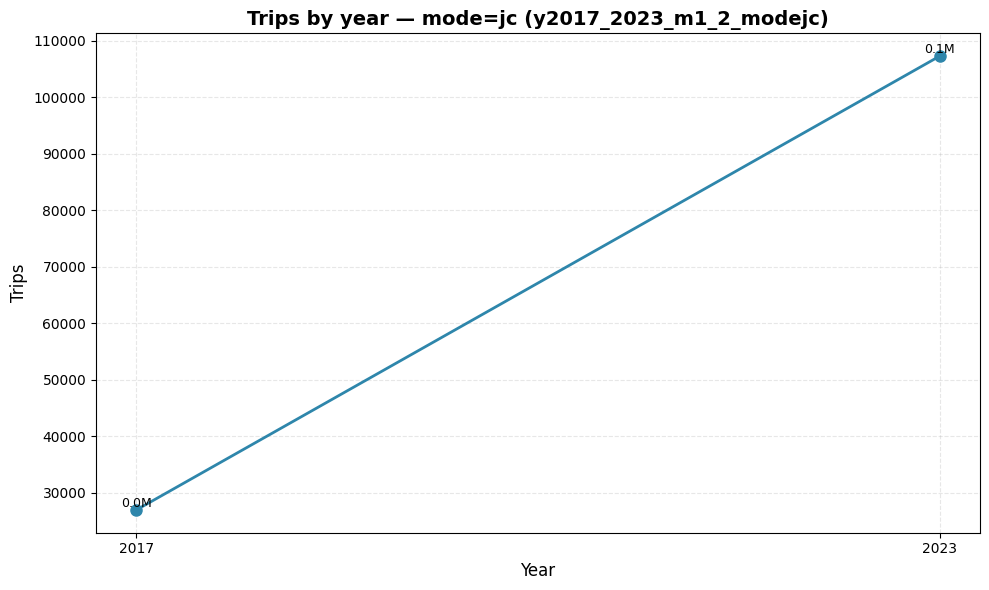

In [3]:
# --- Trips by year (THIS RUN) ---
g = df_year.copy()

if "year" in g.columns:
    # Clean and prepare data
    g["year"] = pd.to_numeric(g["year"], errors="coerce")
    g = g.dropna(subset=["year"]).sort_values("year").reset_index(drop=True)
    
display(g)

# Plot
plt.figure(figsize=(10, 6))

if "year" in g.columns and "trips" in g.columns:
    # Extract values as plain lists (no pandas magic)
    years = [int(y) for y in g["year"]]
    trips = [int(t) for t in g["trips"]]
    
    # Plot with explicit year labels
    plt.plot(years, trips, marker="o", linewidth=2, markersize=8, color='#2E86AB')
    plt.xticks(years, [str(y) for y in years])  # Explicit year labels
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Add value labels on points
    for year, trip in zip(years, trips):
        plt.text(year, trip, f'{trip/1e6:.1f}M', 
                ha='center', va='bottom', fontsize=9)

plt.title(f"Trips by year — mode={mode} ({run_label})", fontsize=14, fontweight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Trips", fontsize=12)
plt.tight_layout()

savefig("01_trips_by_year.png")
plt.show()


## 2) Month patterns (comparison)

,mode,year,month,trips,active_days,trips_per_day
0,jc,2017,1,12926,31,416.967742
1,jc,2017,2,14026,27,519.481481
2,jc,2023,1,56075,31,1808.870968
3,jc,2023,2,51213,28,1829.035714


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2017_2023_m1_2_modejc/figures/02_trips_by_year_month.png


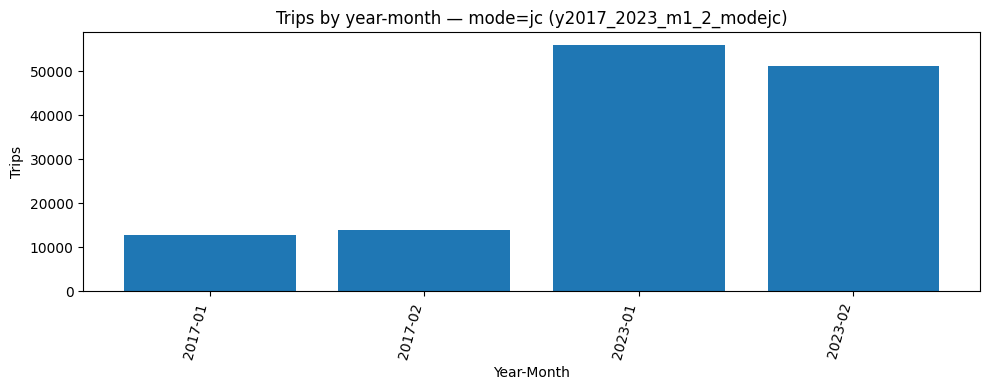

In [4]:
# --- Trips by month (THIS RUN) ---
m = df_month.copy()

# Normalize month labels
if "month" in m.columns:
    m["month"] = pd.to_numeric(m["month"], errors="coerce").astype("Int64")
if "year" in m.columns:
    m["year"] = pd.to_numeric(m["year"], errors="coerce").astype("Int64")

display(m.sort_values([c for c in ["year", "month"] if c in m.columns]))

# If multiple years, show stacked-ish bars by year-month
if {"year", "month", "trips"}.issubset(m.columns):
    m2 = m.dropna(subset=["year","month"]).copy()
    m2["ym"] = m2["year"].astype(int).astype(str) + "-" + m2["month"].astype(int).astype(str).str.zfill(2)

    plt.figure(figsize=(10,4))
    plt.bar(m2["ym"], m2["trips"])
    plt.title(f"Trips by year-month — mode={mode} ({run_label})")
    plt.xlabel("Year-Month")
    plt.ylabel("Trips")
    plt.xticks(rotation=75, ha="right")
    plt.tight_layout()
    savefig("02_trips_by_year_month.png")
    plt.show()
else:
    print("Expected columns not present for trips-by-month plot. Have:", list(m.columns))


year,2017,2023
month,,
1,12926,56075
2,14026,51213


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2017_2023_m1_2_modejc/figures/03_month_by_year_lines.png


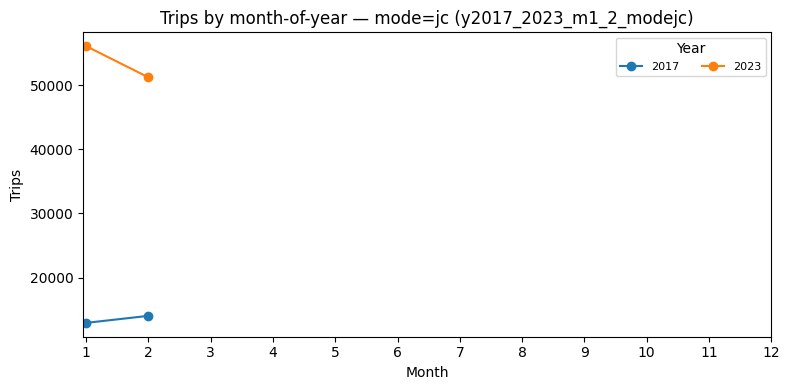

In [5]:
# --- Month-of-year seasonality (line chart per year) ---
m = df_month.copy()
if not {"year","month","trips"}.issubset(m.columns):
    print("Month table missing required columns:", list(m.columns))
else:
    m["year"]  = pd.to_numeric(m["year"], errors="coerce").astype("Int64")
    m["month"] = pd.to_numeric(m["month"], errors="coerce").astype("Int64")
    m = m.dropna(subset=["year","month"]).copy()
    m = m.sort_values(["year","month"])

    pivot = m.pivot_table(index="month", columns="year", values="trips", aggfunc="sum").sort_index()
    display(pivot)

    plt.figure(figsize=(8,4))
    for y in pivot.columns:
        plt.plot(pivot.index.astype(int), pivot[y], marker="o", label=str(int(y)))
    plt.title(f"Trips by month-of-year — mode={mode} ({run_label})")
    plt.xlabel("Month")
    plt.ylabel("Trips")
    plt.xticks(range(1,13))
    plt.legend(title="Year", ncol=2, fontsize=8)
    plt.tight_layout()
    savefig("03_month_by_year_lines.png")
    plt.show()


## 3) Day-of-week patterns (comparison)

,mode,year,dow,dow_name,week_part,trips,pct_of_mode_year_trips,pct_within_week_part
0,jc,2017,0,Monday,weekday,3919,14.540665,18.362853
1,jc,2017,1,Tuesday,weekday,4310,15.991392,20.194921
2,jc,2017,2,Wednesday,weekday,4869,18.065450,22.814169
3,jc,2017,3,Thursday,weekday,4234,15.709409,19.838815
4,jc,2017,4,Friday,weekday,4010,14.878302,18.789242
5,jc,2017,5,Saturday,weekend,2781,10.318344,49.572193
6,jc,2017,6,Sunday,weekend,2829,10.496438,50.427807
7,jc,2023,0,Monday,weekday,16892,15.744538,21.170042
8,jc,2023,1,Tuesday,weekday,16665,15.532958,20.885552
9,jc,2023,2,Wednesday,weekday,16254,15.149877,20.370463


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2017_2023_m1_2_modejc/figures/04_trips_by_dow.png


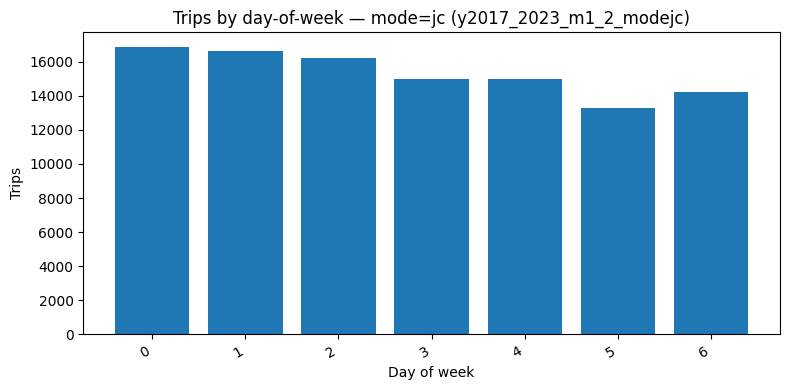

In [6]:
# --- Trips by day-of-week (THIS RUN) ---
d = df_dow.copy()
display(d)

# Prefer an ordered weekday axis if possible
if "dow" in d.columns:
    order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    d["dow"] = d["dow"].astype(str)
    if set(order).issubset(set(d["dow"].unique())):
        d["dow"] = pd.Categorical(d["dow"], categories=order, ordered=True)
        d = d.sort_values("dow")

if {"dow","trips"}.issubset(d.columns):
    plt.figure(figsize=(8,4))
    plt.bar(d["dow"].astype(str), d["trips"])
    plt.title(f"Trips by day-of-week — mode={mode} ({run_label})")
    plt.xlabel("Day of week")
    plt.ylabel("Trips")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    savefig("04_trips_by_dow.png")
    plt.show()
else:
    print("Day-of-week table missing required columns. Have:", list(d.columns))


## 4) Hour-of-day patterns (comparison)

,mode,year,hour,week_part,trips,pct_of_mode_year_trips,pct_within_week_part
0,jc,2017,0,weekday,138,0.512021,0.646612
1,jc,2017,0,weekend,102,0.378451,1.818182
2,jc,2017,1,weekday,51,0.189225,0.238965
3,jc,2017,1,weekend,61,0.226328,1.087344
4,jc,2017,2,weekday,12,0.044524,0.056227
5,jc,2017,2,weekend,51,0.189225,0.909091
6,jc,2017,3,weekday,10,0.037103,0.046856
7,jc,2017,3,weekend,23,0.085337,0.409982
8,jc,2017,4,weekday,71,0.263431,0.332677
9,jc,2017,4,weekend,33,0.122440,0.588235


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2017_2023_m1_2_modejc/figures/05_trips_by_hour.png


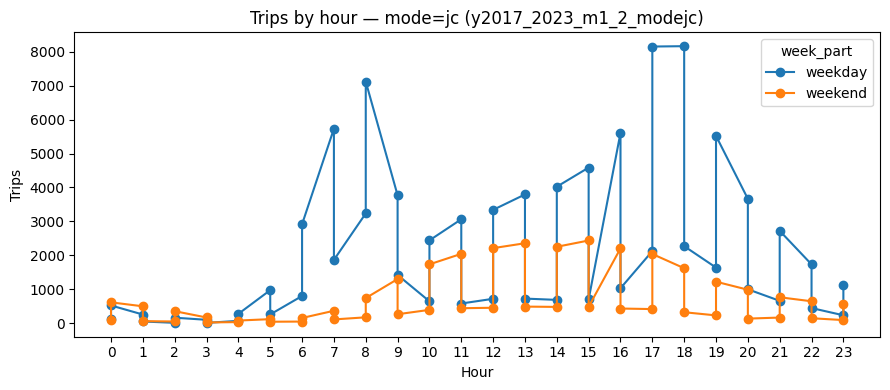

In [7]:
# --- Trips by hour (weekday vs weekend if present) ---
h = df_hour.copy()
display(h.head(20))

# Expect cols: hour, trips, week_part or segment
hour_col = "hour" if "hour" in h.columns else None
trips_col = "trips" if "trips" in h.columns else None
part_col = None
for c in ["week_part","segment","is_weekend"]:
    if c in h.columns:
        part_col = c
        break

if not (hour_col and trips_col):
    print("Hour table missing required columns. Have:", list(h.columns))
else:
    h[hour_col] = pd.to_numeric(h[hour_col], errors="coerce")
    h[trips_col] = pd.to_numeric(h[trips_col], errors="coerce")
    h = h.dropna(subset=[hour_col, trips_col]).sort_values(hour_col)

    if part_col:
        # Plot each segment as its own line
        plt.figure(figsize=(9,4))
        for seg, sub in h.groupby(part_col):
            sub = sub.sort_values(hour_col)
            plt.plot(sub[hour_col], sub[trips_col], marker="o", label=str(seg))
        plt.title(f"Trips by hour — mode={mode} ({run_label})")
        plt.xlabel("Hour")
        plt.ylabel("Trips")
        plt.xticks(range(0,24,1), rotation=0)
        plt.legend(title=part_col)
        plt.tight_layout()
        savefig("05_trips_by_hour.png")
        plt.show()
    else:
        plt.figure(figsize=(9,4))
        plt.plot(h[hour_col], h[trips_col], marker="o")
        plt.title(f"Trips by hour — mode={mode} ({run_label})")
        plt.xlabel("Hour")
        plt.ylabel("Trips")
        plt.xticks(range(0,24,1), rotation=0)
        plt.tight_layout()
        savefig("05_trips_by_hour.png")
        plt.show()


## 5) Station exposure (optional)

,mode,year,month,station_id,station_name,trips,start_trips,end_trips,touchpoints,station_lat,station_lng
81,jc,2023,1,JC115,Grove St PATH,6121,2953,3168,6121,40.719392,-74.043108
162,jc,2023,2,JC115,Grove St PATH,5986,2785,3201,5986,40.719393,-74.043106
82,jc,2023,1,HB102,Hoboken Terminal - River St & Hudson Pl,5627,2850,2777,5627,40.736083,-74.029125
163,jc,2023,2,HB102,Hoboken Terminal - River St & Hudson Pl,5330,2679,2651,5330,40.736084,-74.029130
0,jc,2017,1,3186,Grove St PATH,3881,1638,2243,3881,40.719586,-74.043117
40,jc,2017,2,3186,Grove St PATH,3804,1634,2170,3804,40.719586,-74.043117
83,jc,2023,1,HB103,South Waterfront Walkway - Sinatra Dr & 1 St,3555,1783,1772,3555,40.737006,-74.027773
84,jc,2023,1,HB101,Hoboken Terminal - Hudson St & Hudson Pl,3471,1734,1737,3471,40.735937,-74.030314
164,jc,2023,2,HB103,South Waterfront Walkway - Sinatra Dr & 1 St,3312,1631,1681,3312,40.737013,-74.027770
165,jc,2023,2,HB101,Hoboken Terminal - Hudson St & Hudson Pl,3261,1632,1629,3261,40.735937,-74.030315


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2017_2023_m1_2_modejc/figures/06_top_stations_exposure.png


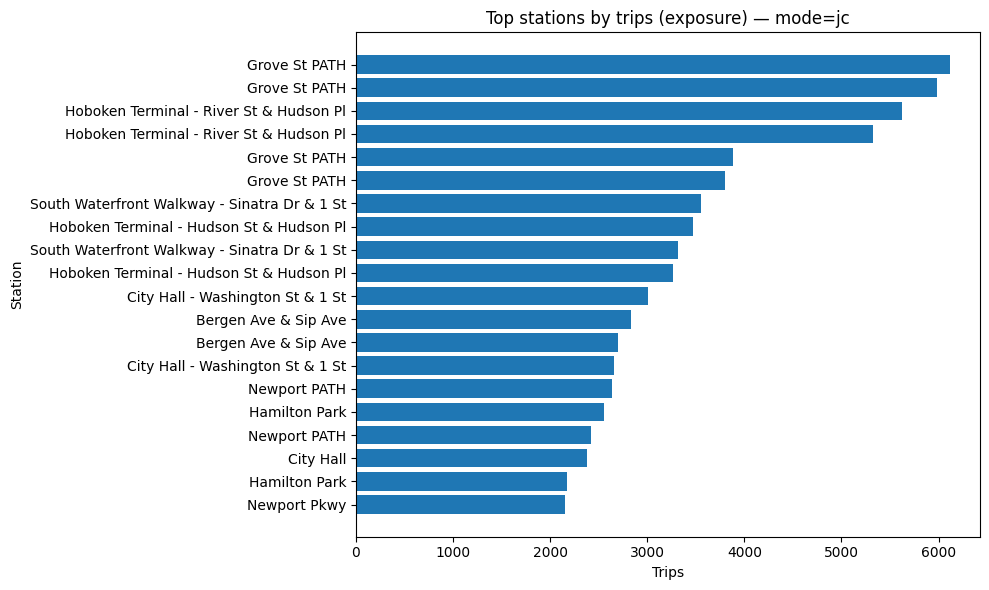

In [8]:
# --- Station exposure: where trips concentrate (policies / riders) ---
if df_station is None:
    print("No station exposure file found (citibike_station_exposure.csv). Skipping.")
else:
    s = df_station.copy()

    # Normalize column names across modes / scripts
    if "station_name" not in s.columns and "start_station_name" in s.columns:
        s = s.rename(columns={"start_station_name": "station_name"})
    if "station_id" not in s.columns and "start_station_id" in s.columns:
        s = s.rename(columns={"start_station_id": "station_id"})

    trips_col = "trips" if "trips" in s.columns else None
    name_col = "station_name" if "station_name" in s.columns else None

    if trips_col is None or name_col is None:
        print("Station exposure table missing required columns. Columns:", list(s.columns))
    else:
        s[trips_col] = pd.to_numeric(s[trips_col], errors="coerce")
        s = s.dropna(subset=[trips_col])
        top = s.sort_values(trips_col, ascending=False).head(20)
        display(top)

        plt.figure(figsize=(10,6))
        _tmp = top.iloc[::-1]  # keep this if you want biggest on top
        y = range(len(_tmp))

        plt.barh(y, _tmp[trips_col].values)
        plt.yticks(y, _tmp[name_col].astype(str))
        plt.title(f"Top stations by trips (exposure) — mode={mode}")
        plt.xlabel("Trips")
        plt.ylabel("Station")
        plt.tight_layout()
        savefig("06_top_stations_exposure.png")
        plt.show()


## 6) Crash proximity / risk proxy (optional)

### 6.1 Station-level prioritization (make the proxy usable)

The raw file includes **crash counts within 250m/500m** of each station plus **trip volume**.  
To avoid misleading outliers (e.g., stations with only a handful of trips), we:

- keep IDs as **strings** (so `2231.10` doesn’t turn into `2231.1`)
- recompute crash-rates per 100k trips (defensive)
- rank **exposure** (most trips) separately from **risk rate** (filtered to stations with enough trips)

You can tune `MIN_TRIPS_FOR_RATE` depending on how conservative you want to be.


Top 20 stations by exposure (trips) — stable only (trips ≥ 5000)


,mode,station_id,station_name,trips
122,jc,JC115,Grove St PATH,12107
42,jc,HB102,Hoboken Terminal - River St & Hudson Pl,10957
3,jc,3186,Grove St PATH,7685
43,jc,HB103,South Waterfront Walkway - Sinatra Dr & 1 St,6867
41,jc,HB101,Hoboken Terminal - Hudson St & Hudson Pl,6732
44,jc,HB105,City Hall - Washington St & 1 St,5660
120,jc,JC109,Bergen Ave & Sip Ave,5534
96,jc,JC066,Newport PATH,5053


Top 20 stations by EB-smoothed crash proxy (500m) — stable only (trips ≥ 5000)


,mode,station_id,station_name,trips,crashes_within_500m,eb_rate_per_100k_trips
3,jc,3186,Grove St PATH,7685,0,0.0
41,jc,HB101,Hoboken Terminal - Hudson St & Hudson Pl,6732,0,0.0
42,jc,HB102,Hoboken Terminal - River St & Hudson Pl,10957,0,0.0
43,jc,HB103,South Waterfront Walkway - Sinatra Dr & 1 St,6867,0,0.0
44,jc,HB105,City Hall - Washington St & 1 St,5660,0,0.0
96,jc,JC066,Newport PATH,5053,0,0.0
120,jc,JC109,Bergen Ave & Sip Ave,5534,0,0.0
122,jc,JC115,Grove St PATH,12107,0,0.0


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2017_2023_m1_2_modejc/figures/09_scatter_trips_vs_EB_crash_rate_500m_trips_ge_5000.png


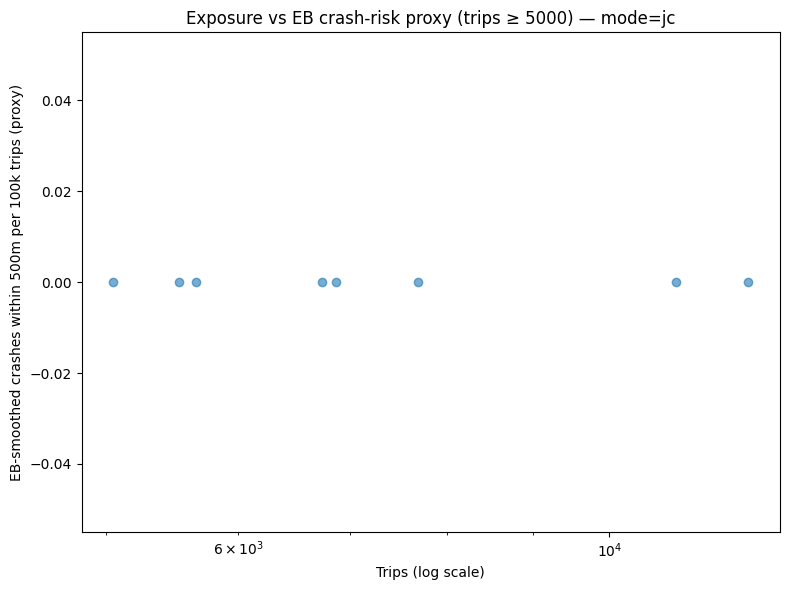

In [9]:
# --- Crash proximity risk proxy (NYC only): radius-aware + robust ---
# This section automatically uses the same radius as the AXA scorecard run
# (passed via Makefile as AXA_RADIUS, e.g. "450m").
#
# Why: the risk CSV only contains the radii that were computed during summarize (--radii-m).
# So the notebook must pick a radius that exists in df_risk.

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MIN_TRIPS_FOR_RATE = 5000
TOP_N = 20
EB_M_PRIOR = 20000.0
SCALE = 100000.0

_RADIUS_RE = re.compile(r"^\s*(\d+(?:\.\d+)?)\s*(m|km)?\s*$", re.IGNORECASE)

def parse_radius_to_m(raw: str) -> int:
    s = (raw or "").strip().lower()
    if s in ("", "auto", "max"):
        return -1
    m = _RADIUS_RE.match(s)
    if not m:
        raise ValueError(f"Bad AXA_RADIUS={raw!r}. Use like 450m, 750, 1km, auto.")
    val = float(m.group(1))
    unit = (m.group(2) or "m").lower()
    meters = val * (1000.0 if unit == "km" else 1.0)
    if meters <= 0:
        raise ValueError(f"AXA_RADIUS must be > 0 (got {raw!r})")
    return int(round(meters))

def available_radii(df: pd.DataFrame) -> list[int]:
    radii = []
    for c in df.columns:
        mm = re.match(r"^crashes_within_(\d+)m$", str(c))
        if mm:
            radii.append(int(mm.group(1)))
    return sorted(set(radii))

def ensure_int_col(df: pd.DataFrame, col: str) -> None:
    if col not in df.columns:
        df[col] = 0
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

def eb_rate_per_trip(k: np.ndarray, e: np.ndarray, m_prior: float) -> np.ndarray:
    """EB smoothing for Poisson rate per trip: (k + r0*m)/(e+m), r0=sum(k)/sum(e)."""
    k = k.astype(float)
    e = e.astype(float)
    e_sum = float(np.nansum(e))
    r0 = float(np.nansum(k) / e_sum) if e_sum > 0 else 0.0
    return (k + r0 * m_prior) / (e + m_prior)

if df_risk is None:
    print("No station risk file found (station_risk_exposure_plus_crashproximity.csv). Skipping crash-proxy section.")
else:
    r = df_risk.copy()

    # Normalize ids/names (so downstream tables are stable)
    if "station_id" not in r.columns and "start_station_id" in r.columns:
        r = r.rename(columns={"start_station_id": "station_id"})
    if "station_name" not in r.columns and "start_station_name" in r.columns:
        r = r.rename(columns={"start_station_name": "station_name"})

    # Trips cleaning
    r["trips"] = pd.to_numeric(r.get("trips", pd.NA), errors="coerce")
    r = r.dropna(subset=["trips"]).copy()
    r = r[r["trips"] > 0].copy()

    # Choose radius: prefer AXA_RADIUS, else pick max available
    avail = available_radii(r)
    if not avail:
        print("No crashes_within_<R>m columns found in df_risk. Skipping crash-proxy section.")
    else:
        env_raw = os.environ.get("AXA_RADIUS", "auto")
        wanted_m = parse_radius_to_m(env_raw)

        if wanted_m == -1:
            chosen_m = max(avail)
        else:
            chosen_m = wanted_m
            if chosen_m not in avail:
                fallback = 500 if 500 in avail else max(avail)
                print(f"Requested radius {chosen_m}m not in df_risk. Available={avail}. Falling back to {fallback}m.")
                chosen_m = fallback

        crash_col = f"crashes_within_{chosen_m}m"
        rate_col = f"{crash_col}_per_100k_trips"

        ensure_int_col(r, crash_col)

        ## Compute canonical raw rate (keep one naming scheme)
        #r[rate_col] = (r[crash_col] / r["trips"].replace({0: np.nan})) * SCALE
        #r[rate_col] = pd.to_numeric(r[rate_col], errors="coerce").fillna(0.0)

        #print(f"Using radius={chosen_m}m -> {crash_col}, {rate_col}")

        #print("Diagnostic: lowest-trip stations -> raw per-100k rates explode (tiny denominator)")
        #display(
        #    r.sort_values("trips", ascending=True)
        #     .head(10)[["mode","station_id","station_name","trips", crash_col, rate_col]]
        #)

        # Stable subset for ranking
        stable = r[r["trips"] >= MIN_TRIPS_FOR_RATE].copy()
        if stable.empty:
            print(f"No stations with trips >= {MIN_TRIPS_FOR_RATE}. Risk ranking skipped.")
        else:
            stable["eb_rate_per_100k_trips"] = eb_rate_per_trip(
                stable[crash_col].to_numpy(),
                stable["trips"].to_numpy(),
                EB_M_PRIOR,
            ) * SCALE

            print(f"Top {TOP_N} stations by exposure (trips) — stable only (trips ≥ {MIN_TRIPS_FOR_RATE})")
            display(
                stable.sort_values("trips", ascending=False)
                      .head(TOP_N)[["mode","station_id","station_name","trips"]]
            )

            print(f"Top {TOP_N} stations by EB-smoothed crash proxy ({chosen_m}m) — stable only (trips ≥ {MIN_TRIPS_FOR_RATE})")
            display(
                stable.sort_values("eb_rate_per_100k_trips", ascending=False)
                      .head(TOP_N)[["mode","station_id","station_name","trips", crash_col, "eb_rate_per_100k_trips"]]
            )

            # Quick plot: exposure vs EB risk
            plt.figure(figsize=(8, 6))
            plt.scatter(stable["trips"], stable["eb_rate_per_100k_trips"], alpha=0.6)
            plt.xscale("log")
            plt.xlabel("Trips (log scale)")
            plt.ylabel(f"EB-smoothed crashes within {chosen_m}m per 100k trips (proxy)")
            plt.title(f"Exposure vs EB crash-risk proxy (trips ≥ {MIN_TRIPS_FOR_RATE}) — mode={mode}")
            plt.tight_layout()
            savefig(f"09_scatter_trips_vs_EB_crash_rate_{chosen_m}m_trips_ge_{MIN_TRIPS_FOR_RATE}.png")
            plt.show()


### 6.2 Alternative Risk Metrics (Intuitive Formats)

The standard `per_100k_trips` metric is useful for technical analysis, but can be hard to interpret.
This section adds alternative formats that are more intuitive for different audiences:

- **Percentage** (crash_rate_pct): Good for executives
- **Trips per crash**: Most intuitive for general public
- **Risk level**: Classification (Very Low → Very High)
- **Risk score**: 0-100 ranking score

,stations
zone,
High exposure / High risk,4
Lower exposure / High risk,4


Saved: /home/maral/Desktop/citibike-insurance-challenge/reports/y2017_2023_m1_2_modejc/figures/10_zones_exposure_vs_risk_500m_trips_ge_5000.png


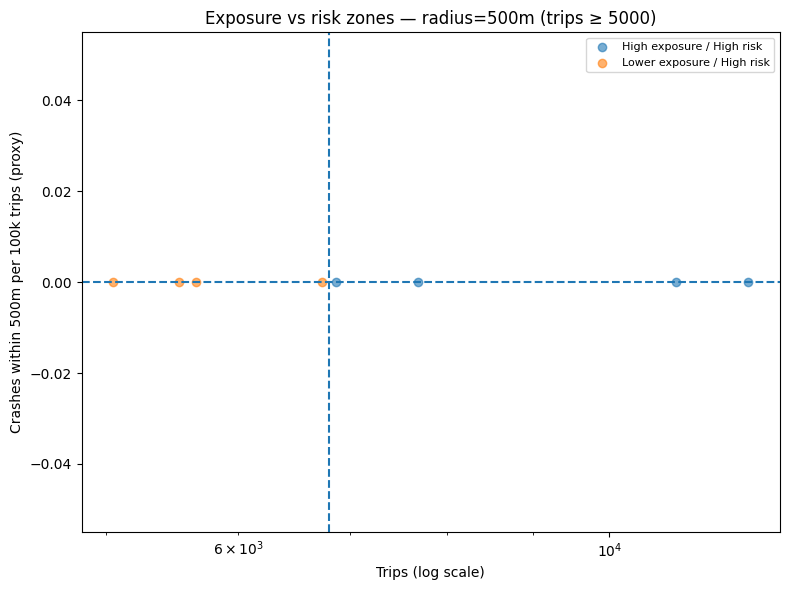

High exposure + high proxy risk (top 15):


,mode,station_id,station_name,trips,crashes_within_500m,crashes_per_100k_trips
122,jc,JC115,Grove St PATH,12107,0,0.0
42,jc,HB102,Hoboken Terminal - River St & Hudson Pl,10957,0,0.0
3,jc,3186,Grove St PATH,7685,0,0.0
43,jc,HB103,South Waterfront Walkway - Sinatra Dr & 1 St,6867,0,0.0


In [10]:
# --- Exposure vs Risk "Zones" (simple quadrant view, radius-aware) ---
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MIN_TRIPS_FOR_ZONES = 5000
SCALE = 100000.0

_RADIUS_RE = re.compile(r"^\s*(\d+(?:\.\d+)?)\s*(m|km)?\s*$", re.IGNORECASE)

def parse_radius_to_m(raw: str) -> int:
    s = (raw or "").strip().lower()
    if s in ("", "auto", "max"):
        return -1
    m = _RADIUS_RE.match(s)
    if not m:
        return -1
    val = float(m.group(1))
    unit = (m.group(2) or "m").lower()
    meters = val * (1000.0 if unit == "km" else 1.0)
    return int(round(meters)) if meters > 0 else -1

def available_radii(df: pd.DataFrame) -> list[int]:
    radii = []
    for c in df.columns:
        mm = re.match(r"^crashes_within_(\d+)m$", str(c))
        if mm:
            radii.append(int(mm.group(1)))
    return sorted(set(radii))

def ensure_int_col(df: pd.DataFrame, col: str) -> None:
    if col not in df.columns:
        df[col] = 0
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

if df_risk is None:
    print("No station risk file found. Skipping zones plot.")
else:
    r = df_risk.copy()
    if "station_id" not in r.columns and "start_station_id" in r.columns:
        r = r.rename(columns={"start_station_id": "station_id"})
    if "station_name" not in r.columns and "start_station_name" in r.columns:
        r = r.rename(columns={"start_station_name": "station_name"})

    r["trips"] = pd.to_numeric(r.get("trips", pd.NA), errors="coerce")
    r = r.dropna(subset=["trips"]).copy()
    r = r[r["trips"] > 0].copy()

    avail = available_radii(r)
    if not avail:
        print("No crashes_within_<R>m columns found. Skipping zones plot.")
    else:
        env_raw = os.environ.get("AXA_RADIUS", "auto")
        wanted = parse_radius_to_m(env_raw)
        chosen = max(avail) if wanted == -1 else (wanted if wanted in avail else (500 if 500 in avail else max(avail)))

        crash_col = f"crashes_within_{chosen}m"
        ensure_int_col(r, crash_col)

        r = r[(r["trips"] >= MIN_TRIPS_FOR_ZONES)].copy()
        if len(r) == 0:
            print("No stations meet trips ≥", MIN_TRIPS_FOR_ZONES, "— skipping zones plot.")
        else:
            r["crashes_per_100k_trips"] = (r[crash_col] / r["trips"].replace({0: np.nan})) * SCALE
            r["crashes_per_100k_trips"] = pd.to_numeric(r["crashes_per_100k_trips"], errors="coerce").fillna(0.0)

            x = r["trips"].astype(float)
            y = r["crashes_per_100k_trips"].astype(float)

            x_med = float(np.nanmedian(x))
            y_med = float(np.nanmedian(y))
            
            def zone(row):
                hi_x = float(row["trips"]) >= x_med
                # FIX 1: use the radius-aware metric you computed
                hi_y = float(row["crashes_per_100k_trips"]) >= y_med
                if hi_x and hi_y:
                    return "High exposure / High risk"
                if hi_x and (not hi_y):
                    return "High exposure / Lower risk"
                if (not hi_x) and hi_y:
                    return "Lower exposure / High risk"
                return "Lower exposure / Lower risk"
            
            r["zone"] = r.apply(zone, axis=1)
            display(r["zone"].value_counts().to_frame("stations"))

            # Plot quadrants
            plt.figure(figsize=(8, 6))
            for z, sub in r.groupby("zone"):
                # FIX 2: plot the column that exists
                plt.scatter(sub["trips"], sub["crashes_per_100k_trips"], alpha=0.6, label=z)

            plt.axvline(x_med, linestyle="--")
            plt.axhline(y_med, linestyle="--")
            plt.xscale("log")
            plt.xlabel("Trips (log scale)")
            plt.ylabel(f"Crashes within {chosen}m per 100k trips (proxy)")
            plt.title(f"Exposure vs risk zones — radius={chosen}m (trips ≥ {MIN_TRIPS_FOR_ZONES})")
            plt.legend(fontsize=8)
            plt.tight_layout()
            savefig(f"10_zones_exposure_vs_risk_{chosen}m_trips_ge_{MIN_TRIPS_FOR_ZONES}.png")
            plt.show()
            # FIX 3: use plt.savefig
            #plt.savefig(f"10_zones_exposure_vs_risk_{chosen}m_trips_ge_{MIN_TRIPS_FOR_ZONES}.png", dpi=200)
            #plt.show()

            # Small table of "high-high" quadrant
            hh = r[(x >= x_med) & (y >= y_med)].copy()
            hh = hh.sort_values(["crashes_per_100k_trips", "trips"], ascending=False).head(15)
            print("High exposure + high proxy risk (top 15):")
            display(hh[["mode","station_id","station_name","trips", crash_col, "crashes_per_100k_trips"]])
            
            
            #crash_col = "crashes_within_900m"  # or your chosen crash_col variable
            #print("non-zero stations:", (df_risk[crash_col] > 0).sum())
            #print("total crashes counted:", int(df_risk[crash_col].sum()))
            tmp = df_risk.copy()

 
            
            


            



## 7) AXA Partner Decision Assets: Where + When + What

This section turns your outputs into **two decision assets**:

- **WHERE to focus** (stations): `axa_partner_scorecard_500m.csv`
- **WHEN to activate** (time windows): `axa_target_windows.csv`

Both files are produced by the Make targets you already ran.


In [11]:
# --- Load AXA assets for THIS run_dir (radius-aware, no global fallback) ---
from __future__ import annotations

from pathlib import Path
import os
import re
import pandas as pd

_RADIUS_RE = re.compile(r"^\s*(\d+(?:\.\d+)?)\s*(m|km)?\s*$", re.IGNORECASE)

def parse_radius_to_m(raw: str) -> int:
    s = (raw or "").strip().lower()
    if s in ("", "auto", "max"):
        return -1
    m = _RADIUS_RE.match(s)
    if not m:
        raise ValueError(f"Bad AXA_RADIUS={raw!r}. Use like 450m, 750, 1km, auto.")
    val = float(m.group(1))
    unit = (m.group(2) or "m").lower()
    meters = val * (1000.0 if unit == "km" else 1.0)
    if meters <= 0:
        raise ValueError(f"AXA_RADIUS must be > 0 (got {raw!r})")
    return int(round(meters))

def available_scorecards(run_dir: Path) -> list[int]:
    radii = []
    for p in run_dir.glob("axa_partner_scorecard_*m.csv"):
        mm = re.match(r"^axa_partner_scorecard_(\d+)m\.csv$", p.name)
        if mm:
            radii.append(int(mm.group(1)))
    return sorted(set(radii))

def scorecard_path_for_radius(run_dir: Path, radius_env: str) -> Path | None:
    avail = available_scorecards(run_dir)
    if not avail:
        return None
    wanted = parse_radius_to_m(radius_env)
    if wanted == -1:
        chosen = max(avail)
    else:
        chosen = wanted if wanted in avail else (500 if 500 in avail else max(avail))
    p = run_dir / f"axa_partner_scorecard_{chosen}m.csv"
    return p if p.exists() else None

radius_env = os.environ.get("AXA_RADIUS", "auto")
scorecard_path = scorecard_path_for_radius(RUN_DIR, radius_env)

windows_path = RUN_DIR / "axa_target_windows.csv"

df_score = pd.read_csv(scorecard_path) if scorecard_path and scorecard_path.exists() else None
df_windows = pd.read_csv(windows_path) if windows_path.exists() else None

print("AXA_RADIUS (env):", radius_env)
print("Scorecard path:", scorecard_path if scorecard_path else "NOT FOUND")
print("Windows path:", windows_path if windows_path.exists() else "NOT FOUND")

print("df_score is None?", df_score is None)
print("df_windows is None?", df_windows is None)
print("CWD:", os.getcwd())

if df_score is not None:
    display(df_score.head(10))
if df_windows is not None:
    display(df_windows.head(10))


AXA_RADIUS (env): 500m
Scorecard path: /home/maral/Desktop/citibike-insurance-challenge/summaries/y2017_2023_m1_2_modejc/axa_partner_scorecard_500m.csv
Windows path: /home/maral/Desktop/citibike-insurance-challenge/summaries/y2017_2023_m1_2_modejc/axa_target_windows.csv
df_score is None? False
df_windows is None? False
CWD: /home/maral/Desktop/citibike-insurance-challenge/notebooks


,mode,start_station_id,start_station_name,station_lat,station_lng,exposure_trips,crash_count,risk_rate_per_100k_trips,risk_rate_ci_low,risk_rate_ci_high,...,risk_pct,axa_priority_score,prevention_hotspot,product_hotspot,acquisition_hotspot,exposure_index_pct,eb_risk_rate_per_100k_trips,risk_index_pct,expected_incidents_proxy,scoring_strategy
0,jc,JC115,Grove St PATH,40.719392,-74.043107,12107,0,0.0,0.0,30.468980,...,0.0,1.000000,True,True,True,100.000000,NaN,NaN,NaN,exposure_only_no_risk_signal
1,jc,HB102,Hoboken Terminal - River St & Hudson Pl,40.736084,-74.029128,10957,0,0.0,0.0,33.666875,...,0.0,0.991870,True,True,True,99.186992,NaN,NaN,NaN,exposure_only_no_risk_signal
2,jc,3186,Grove St PATH,40.719586,-74.043117,7685,0,0.0,0.0,48.001034,...,0.0,0.983740,True,True,True,98.373984,NaN,NaN,NaN,exposure_only_no_risk_signal
3,jc,HB103,South Waterfront Walkway - Sinatra Dr & 1 St,40.737010,-74.027772,6867,0,0.0,0.0,53.718938,...,0.0,0.975610,True,True,True,97.560976,NaN,NaN,NaN,exposure_only_no_risk_signal
4,jc,HB101,Hoboken Terminal - Hudson St & Hudson Pl,40.735937,-74.030315,6732,0,0.0,0.0,54.796189,...,0.0,0.967480,True,True,True,96.747967,NaN,NaN,NaN,exposure_only_no_risk_signal
5,jc,HB105,City Hall - Washington St & 1 St,40.737338,-74.030987,5660,0,0.0,0.0,65.174549,...,0.0,0.959350,True,True,True,95.934959,NaN,NaN,NaN,exposure_only_no_risk_signal
6,jc,JC109,Bergen Ave & Sip Ave,40.731032,-74.064437,5534,0,0.0,0.0,66.658465,...,0.0,0.951220,True,True,True,95.121951,NaN,NaN,NaN,exposure_only_no_risk_signal
7,jc,JC066,Newport PATH,40.727219,-74.033753,5053,0,0.0,0.0,73.003749,...,0.0,0.943089,True,True,True,94.308943,NaN,NaN,NaN,exposure_only_no_risk_signal
8,jc,JC009,Hamilton Park,40.727581,-74.044248,4722,0,0.0,0.0,78.121124,...,0.0,0.934959,True,True,True,93.495935,NaN,NaN,NaN,exposure_only_no_risk_signal
9,jc,JC003,City Hall,40.717730,-74.043852,4348,0,0.0,0.0,84.840834,...,0.0,0.926829,True,True,True,92.682927,NaN,NaN,NaN,exposure_only_no_risk_signal


,window_type,segment,window_label,trips,pct_of_mode_year_trips,pct_within_week_part,priority_metric,recommended_action
0,hour_peak,weekday,18:00,8165,7.610357,10.232855,10.232855,Acquisition + product upsell (commute peaks); ...
1,hour_peak,weekday,17:00,8154,7.600104,10.219070,10.219070,Acquisition + product upsell (commute peaks); ...
2,hour_peak,weekday,08:00,7122,6.638207,8.925707,8.925707,Acquisition + product upsell (commute peaks); ...
3,hour_peak,weekday,07:00,5733,5.343561,7.184931,7.184931,Acquisition + product upsell (commute peaks); ...
4,hour_peak,weekday,16:00,5610,5.228917,7.030780,7.030780,Acquisition + product upsell (commute peaks); ...
5,hour_peak,weekend,15:00,2438,2.272388,8.866744,8.866744,Leisure targeting + safety messaging
6,hour_peak,weekend,13:00,2357,2.196891,8.572156,8.572156,Leisure targeting + safety messaging
7,hour_peak,weekend,14:00,2253,2.099955,8.193919,8.193919,Leisure targeting + safety messaging
8,hour_peak,weekend,12:00,2213,2.062672,8.048443,8.048443,Leisure targeting + safety messaging
9,hour_peak,weekend,16:00,2205,2.055216,8.019348,8.019348,Leisure targeting + safety messaging


In [12]:
# --- EB-enrich the AXA scorecard (so priority behaves like an insurer) ---
# We compute a credibility-smoothed (Empirical Bayes) risk rate and an insurer-ish priority:
#   expected_incidents_proxy = EB_rate_per_trip * exposure_trips
# This avoids tiny-station outliers and produces a "risk × exposure" ranking.

import numpy as np
import pandas as pd

MIN_TRIPS_FOR_SIGNAL = 5000
EB_M_PRIOR = 20000.0
SCALE = 100000.0

if df_score is None:
    print("No scorecard loaded (df_score is None). Skipping EB enrichment.")
else:
    s = df_score.copy()

    # Normalize column names
    if "station_id" not in s.columns and "start_station_id" in s.columns:
        s = s.rename(columns={"start_station_id": "station_id"})
    if "station_name" not in s.columns and "start_station_name" in s.columns:
        s = s.rename(columns={"start_station_name": "station_name"})
    if "exposure_trips" not in s.columns and "trips" in s.columns:
        s = s.rename(columns={"trips": "exposure_trips"})

    # Ensure mode exists
    if "mode" not in s.columns:
        s["mode"] = mode

    # Ensure numerics
    for c in ["exposure_trips", "crash_count", "risk_rate_per_100k_trips"]:
        if c in s.columns:
            s[c] = pd.to_numeric(s[c], errors="coerce")

    # If crash_count missing, we cannot do EB
    if "crash_count" not in s.columns:
        print("Scorecard missing crash_count; EB enrichment skipped.")
    else:
        def eb_per_trip(k: pd.Series, e: pd.Series, m_prior: float) -> pd.Series:
            e_sum = float(e.sum())
            r0 = float(k.sum() / e_sum) if e_sum > 0 else 0.0
            return (k + r0 * m_prior) / (e + m_prior)

        out_parts = []
        for m, g in s.groupby("mode", dropna=False):
            g = g.copy()

            g["exposure_trips"] = g["exposure_trips"].fillna(0).astype(float)
            g["crash_count"] = g["crash_count"].fillna(0).astype(float)

            stable = g["exposure_trips"] >= float(MIN_TRIPS_FOR_SIGNAL)

            # Determine if proxy has usable signal in this mode
            if "risk_rate_per_100k_trips" in g.columns and g["risk_rate_per_100k_trips"].notna().any():
                risk_has_signal = (g.loc[stable, "risk_rate_per_100k_trips"].nunique(dropna=True) > 1) if stable.any() else False
            else:
                risk_has_signal = (g.loc[stable, "crash_count"].nunique(dropna=True) > 1) if stable.any() else False

            g["risk_proxy_available"] = bool(risk_has_signal)

            # Exposure percentile (always)
            g["exposure_index_pct"] = g["exposure_trips"].rank(pct=True, method="average") * 100.0 if g["exposure_trips"].nunique() > 1 else 50.0

            if not risk_has_signal:
                # JC-style: exposure only
                g["eb_risk_rate_per_100k"] = np.nan
                g["expected_incidents_proxy"] = np.nan
                g["eb_priority_score"] = g["exposure_index_pct"]  # 0..100
                g["scoring_strategy"] = "exposure_only_no_risk_signal"
                out_parts.append(g)
                continue

            # EB rate and expected incidents proxy
            eb_rate = eb_per_trip(g["crash_count"], g["exposure_trips"], float(EB_M_PRIOR))
            g["eb_risk_rate_per_100k"] = eb_rate * SCALE
            g["expected_incidents_proxy"] = eb_rate * g["exposure_trips"]

            # Priority = percentile of expected incidents (0..100)
            g["eb_priority_score"] = g["expected_incidents_proxy"].rank(pct=True, method="average") * 100.0 if g["expected_incidents_proxy"].nunique() > 1 else 50.0
            g["scoring_strategy"] = f"eb_expected_incidents_mprior{int(EB_M_PRIOR)}"

            out_parts.append(g)

        s2 = pd.concat(out_parts, ignore_index=True)

        # Simple action tags
        s2["eb_prevention_hotspot"] = (s2["exposure_index_pct"] >= 80.0) & (s2["eb_priority_score"] >= 80.0)
        s2["eb_product_hotspot"] = (s2["exposure_index_pct"] >= 80.0)
        s2["eb_acquisition_hotspot"] = (s2["exposure_index_pct"] >= 70.0) & (s2.get("eb_risk_rate_per_100k").fillna(0) <= s2.get("eb_risk_rate_per_100k").median())

        df_score = s2  # overwrite for downstream cells

        print("EB enrichment complete. Proxy available share by mode:")
        display(df_score.groupby("mode")["risk_proxy_available"].mean().to_frame("proxy_available_share"))

        display(
            df_score.sort_values("eb_priority_score", ascending=False)
                    .head(15)[[
                        "mode","station_id","station_name",
                        "exposure_trips","crash_count","risk_proxy_available",
                        "eb_risk_rate_per_100k","expected_incidents_proxy","eb_priority_score",
                        "scoring_strategy"
                    ]]
        )

        out_path = RUN_DIR / "axa_partner_scorecard_500m_with_eb.csv"
        df_score.to_csv(out_path, index=False)
        print("Wrote:", out_path)
        




EB enrichment complete. Proxy available share by mode:


/home/maral/Desktop/citibike-insurance-challenge/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1213: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,proxy_available_share
mode,
jc,0.0


,mode,station_id,station_name,exposure_trips,crash_count,risk_proxy_available,eb_risk_rate_per_100k,expected_incidents_proxy,eb_priority_score,scoring_strategy
0,jc,JC115,Grove St PATH,12107.0,0.0,False,NaN,NaN,100.000000,exposure_only_no_risk_signal
1,jc,HB102,Hoboken Terminal - River St & Hudson Pl,10957.0,0.0,False,NaN,NaN,99.186992,exposure_only_no_risk_signal
2,jc,3186,Grove St PATH,7685.0,0.0,False,NaN,NaN,98.373984,exposure_only_no_risk_signal
3,jc,HB103,South Waterfront Walkway - Sinatra Dr & 1 St,6867.0,0.0,False,NaN,NaN,97.560976,exposure_only_no_risk_signal
4,jc,HB101,Hoboken Terminal - Hudson St & Hudson Pl,6732.0,0.0,False,NaN,NaN,96.747967,exposure_only_no_risk_signal
5,jc,HB105,City Hall - Washington St & 1 St,5660.0,0.0,False,NaN,NaN,95.934959,exposure_only_no_risk_signal
6,jc,JC109,Bergen Ave & Sip Ave,5534.0,0.0,False,NaN,NaN,95.121951,exposure_only_no_risk_signal
7,jc,JC066,Newport PATH,5053.0,0.0,False,NaN,NaN,94.308943,exposure_only_no_risk_signal
8,jc,JC009,Hamilton Park,4722.0,0.0,False,NaN,NaN,93.495935,exposure_only_no_risk_signal
9,jc,JC003,City Hall,4348.0,0.0,False,NaN,NaN,92.682927,exposure_only_no_risk_signal


Wrote: /home/maral/Desktop/citibike-insurance-challenge/summaries/y2017_2023_m1_2_modejc/axa_partner_scorecard_500m_with_eb.csv


In [13]:
# WHERE + WHEN + WHAT (turn the outputs into decision-ready assets)
import numpy as np
import pandas as pd

if df_score is None or df_windows is None:
    print("AXA assets not available for this run; skipping WHERE/WHEN/WHAT tables.")
else:
    score = df_score.copy()

    # Normalize station columns
    if "station_id" not in score.columns and "start_station_id" in score.columns:
        score = score.rename(columns={"start_station_id": "station_id"})
    if "station_name" not in score.columns and "start_station_name" in score.columns:
        score = score.rename(columns={"start_station_name": "station_name"})

    # Priority preference: EB first (works for NYC; for JC it becomes exposure-only)
    if "eb_priority_score" in score.columns:
        pri_col = "eb_priority_score"
    elif "axa_priority_score" in score.columns:
        pri_col = "axa_priority_score"
    elif "exposure_trips" in score.columns:
        pri_col = "exposure_trips"
    else:
        pri_col = None

    # Columns to display (de-duplicated)
    cols = [
        "mode","station_id","station_name",
        "exposure_trips","crash_count","risk_proxy_available",
        "risk_rate_per_100k_trips","risk_rate_ci_low","risk_rate_ci_high",
        "eb_risk_rate_per_100k","expected_incidents_proxy","eb_priority_score",
        "scoring_strategy",
        "eb_prevention_hotspot","eb_product_hotspot","eb_acquisition_hotspot",
    ]
    cols = [c for c in cols if c in score.columns]
    cols = list(dict.fromkeys(cols))

    # WHERE
    if pri_col is None:
        print("No usable priority column found; showing first 20 rows of scorecard.")
        where_top = score.head(20)
    else:
        # Prefer proxy-covered first (NYC), then rank
        if "risk_proxy_available" in score.columns:
            where_top = score.sort_values(["risk_proxy_available", pri_col], ascending=[False, False]).head(20)
        else:
            where_top = score.sort_values(pri_col, ascending=False).head(20)

    print(f"WHERE to focus — top 20 stations by `{pri_col}`")
    display(where_top[cols] if cols else where_top)

    # WHEN
    w = df_windows.copy()
    for c in ["trips", "index", "lift_pct", "lift_vs_baseline_pct"]:
        if c in w.columns:
            w[c] = pd.to_numeric(w[c], errors="coerce")

    if "lift_vs_baseline_pct" in w.columns:
        w_rank = "lift_vs_baseline_pct"
    elif "lift_pct" in w.columns:
        w_rank = "lift_pct"
    elif "index" in w.columns:
        w_rank = "index"
    elif "trips" in w.columns:
        w_rank = "trips"
    else:
        w_rank = None

    when_top = w.sort_values(w_rank, ascending=False).head(20) if w_rank else w.head(20)
    print(f"WHEN to activate — top 20 windows by `{w_rank}`")
    display(when_top)

    # WHAT (brief, interview-ready)
    print("\nWHAT to propose (one-slide plan):")
    print("- NYC: use EB hotspots for prevention pilots + risk-tiered messaging/offer placement.")
    print("- JC: exposure-led rollout now; Phase 2 = add JC-local crash proxy for real risk tiering.")
    print("- Measure: attach rate, conversion uplift in target windows, and (later) claims frequency once product exists.")


WHERE to focus — top 20 stations by `eb_priority_score`


,mode,station_id,station_name,exposure_trips,crash_count,risk_proxy_available,risk_rate_per_100k_trips,risk_rate_ci_low,risk_rate_ci_high,eb_risk_rate_per_100k,expected_incidents_proxy,eb_priority_score,scoring_strategy,eb_prevention_hotspot,eb_product_hotspot,eb_acquisition_hotspot
0,jc,JC115,Grove St PATH,12107.0,0.0,False,0.0,0.0,30.468980,NaN,NaN,100.000000,exposure_only_no_risk_signal,True,True,False
1,jc,HB102,Hoboken Terminal - River St & Hudson Pl,10957.0,0.0,False,0.0,0.0,33.666875,NaN,NaN,99.186992,exposure_only_no_risk_signal,True,True,False
2,jc,3186,Grove St PATH,7685.0,0.0,False,0.0,0.0,48.001034,NaN,NaN,98.373984,exposure_only_no_risk_signal,True,True,False
3,jc,HB103,South Waterfront Walkway - Sinatra Dr & 1 St,6867.0,0.0,False,0.0,0.0,53.718938,NaN,NaN,97.560976,exposure_only_no_risk_signal,True,True,False
4,jc,HB101,Hoboken Terminal - Hudson St & Hudson Pl,6732.0,0.0,False,0.0,0.0,54.796189,NaN,NaN,96.747967,exposure_only_no_risk_signal,True,True,False
5,jc,HB105,City Hall - Washington St & 1 St,5660.0,0.0,False,0.0,0.0,65.174549,NaN,NaN,95.934959,exposure_only_no_risk_signal,True,True,False
6,jc,JC109,Bergen Ave & Sip Ave,5534.0,0.0,False,0.0,0.0,66.658465,NaN,NaN,95.121951,exposure_only_no_risk_signal,True,True,False
7,jc,JC066,Newport PATH,5053.0,0.0,False,0.0,0.0,73.003749,NaN,NaN,94.308943,exposure_only_no_risk_signal,True,True,False
8,jc,JC009,Hamilton Park,4722.0,0.0,False,0.0,0.0,78.121124,NaN,NaN,93.495935,exposure_only_no_risk_signal,True,True,False
9,jc,JC003,City Hall,4348.0,0.0,False,0.0,0.0,84.840834,NaN,NaN,92.682927,exposure_only_no_risk_signal,True,True,False


WHEN to activate — top 20 windows by `trips`


,window_type,segment,window_label,trips,pct_of_mode_year_trips,pct_within_week_part,priority_metric,recommended_action
24,month_peak,overall,2023-01,56075,NaN,1808.870968,1808.870968,Seasonal campaign planning
23,month_peak,overall,2023-02,51213,NaN,1829.035714,1829.035714,Seasonal campaign planning
17,day_of_week_peak,weekday,Monday,16892,15.744538,21.170042,21.170042,Campaign scheduling + staffing/ops alignment
18,day_of_week_peak,weekday,Tuesday,16665,15.532958,20.885552,20.885552,Campaign scheduling + staffing/ops alignment
19,day_of_week_peak,weekday,Wednesday,16254,15.149877,20.370463,20.370463,Campaign scheduling + staffing/ops alignment
20,day_of_week_peak,weekend,Sunday,14228,13.261502,51.745708,51.745708,Campaign scheduling + staffing/ops alignment
25,month_peak,overall,2017-02,14026,NaN,519.481481,519.481481,Seasonal campaign planning
21,day_of_week_peak,weekend,Saturday,13268,12.366714,48.254292,48.254292,Campaign scheduling + staffing/ops alignment
26,month_peak,overall,2017-01,12926,NaN,416.967742,416.967742,Seasonal campaign planning
10,commuter_hours,weekday,18:00,8165,7.610357,10.232855,10.232855,Strong commuter acquisition + product bundle



WHAT to propose (one-slide plan):
- NYC: use EB hotspots for prevention pilots + risk-tiered messaging/offer placement.
- JC: exposure-led rollout now; Phase 2 = add JC-local crash proxy for real risk tiering.
- Measure: attach rate, conversion uplift in target windows, and (later) claims frequency once product exists.


In [14]:
# (Optional) Quick sanity checks for AXA assets
if 'df_score' in globals() and df_score is not None:
    print("Scorecard columns:", list(df_score.columns))
if 'df_windows' in globals() and df_windows is not None:
    print("Windows columns:", list(df_windows.columns))


Scorecard columns: ['mode', 'station_id', 'station_name', 'station_lat', 'station_lng', 'exposure_trips', 'crash_count', 'risk_rate_per_100k_trips', 'risk_rate_ci_low', 'risk_rate_ci_high', 'risk_proxy_available', 'credibility_flag', 'exposure_pct', 'risk_pct', 'axa_priority_score', 'prevention_hotspot', 'product_hotspot', 'acquisition_hotspot', 'exposure_index_pct', 'eb_risk_rate_per_100k_trips', 'risk_index_pct', 'expected_incidents_proxy', 'scoring_strategy', 'eb_risk_rate_per_100k', 'eb_priority_score', 'eb_prevention_hotspot', 'eb_product_hotspot', 'eb_acquisition_hotspot']
Windows columns: ['window_type', 'segment', 'window_label', 'trips', 'pct_of_mode_year_trips', 'pct_within_week_part', 'priority_metric', 'recommended_action']


## Interpreting the outputs for this run (plain language)

### WHERE (stations)
- **Exposure** = how much the station is used (more touchpoints).
- **Risk proxy** = how crash-dense the surrounding area is (not “Citi Bike crashes”, but a consistent hazard signal).
- Best insurer focus is **High exposure + High risk** stations (largest expected hazard load).
- High exposure + low risk stations are **growth/upsell** targets.

### WHEN (windows)
Use the windows table to choose *activation moments*:
- Weekday peaks are typically commuting hours → best for acquisition + add-on messaging.
- Weekend peaks are leisure → different tone (safety nudges + leisure bundles).

### WHAT (actions)
- **Product**: in-app add-on prompt near high exposure stations during commuter peaks.
- **Prevention**: safety nudges and partner interventions where exposure + risk proxy are both high.


## Where are the generated plots and tables?

Figures are saved under:

- `reports/<RUN_TAG>/figures/`

Key files:
- `09_exposure_vs_risk_zones.png`
- `station_zones.csv`
- `axa_partner_scorecard_500m.csv`
- `axa_target_windows.csv`


## Statistical correctness and limitations (business-safe)

- The “risk proxy” is **proximity to reported crashes**, not confirmed Citi Bike incidents.
- Filtering (`MIN_TRIPS_FOR_RISK`) prevents tiny-sample stations from producing misleadingly extreme rates.
- For partial-month windows (e.g. Jan–Mar), interpret station rankings as “within-window priorities”, not annual truth.
